# FASE 1: ANÁLISIS EXPLORATORIO INICIAL

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pymysql
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import DBSCAN
import logging

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


## Cargar variables de entorno y conectar a BD

In [12]:
load_dotenv()

True

In [42]:
DATABASE_URL = os.getenv('DATABASE_URL')

def connect_to_database():
    """Establece conexión segura con la base de datos"""
    try:
        engine = create_engine(DATABASE_URL)
        with engine.connect() as conn:
            result = conn.execute(text("SELECT 1"))
            logger.info("Conexión a MySQL establecida exitosamente")
            return engine
    except Exception as e:
        logger.error(f"Error al conectar a la base de datos: {e}")
        return None

engine = connect_to_database()

2025-08-11 20:13:21,605 - INFO - Conexión a MySQL establecida exitosamente


#### Query principal para cargar todos los datos

In [44]:
def load_cardiac_data(limit=None):
    """Carga datos de mediciones cardíacas con opción de límite"""
    
    base_query = """
    SELECT 
        ID,
        Usuario_ID,
        Smartwatch_ID,
        Timestamp_medicion,
        Frecuencia_cardiaca,
        Presion_sistolica,
        Presion_diastolica,
        Saturacion_oxigeno,
        Temperatura,
        Nivel_estres,
        Variabilidad_ritmo,
        Estatus,
        Fecha_Registro,
        Fecha_Actualizacion
    FROM tbb_mediciones_cardiacas
    ORDER BY Usuario_ID, Timestamp_medicion
    """
    
    if limit:
        query = base_query + f" LIMIT {limit};"
    else:
        query = base_query + ";"
    
    try:
        df = pd.read_sql_query(query, engine)
        logger.info(f"Datos cargados: {df.shape[0]} registros, {df.shape[1]} columnas")
        return df
    except Exception as e:
        logger.error(f"Error al cargar datos: {e}")
        return None

In [46]:
df_raw = load_cardiac_data()

2025-08-11 20:13:29,469 - INFO - Datos cargados: 7302 registros, 14 columnas


## INFORMACIÓN GENERAL DEL DATASET ORIGINAL

In [48]:
print(f"Dimensiones: {df_raw.shape[0]:,} filas × {df_raw.shape[1]} columnas")
print(f"Memoria utilizada: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dimensiones: 7,302 filas × 14 columnas
Memoria utilizada: 0.89 MB


In [50]:
# Información sobre usuarios
print(f"\nINFORMACIÓN DE USUARIOS:")
print(f"   • Usuarios únicos: {df_raw['Usuario_ID'].nunique():,}")
print(f"   • Dispositivos únicos: {df_raw['Smartwatch_ID'].nunique():,}")


INFORMACIÓN DE USUARIOS:
   • Usuarios únicos: 10
   • Dispositivos únicos: 10


In [52]:
# Estadísticas por usuario
user_stats = df_raw.groupby('Usuario_ID').agg({
    'ID': 'count',
    'Timestamp_medicion': ['min', 'max'],
    'Smartwatch_ID': 'nunique'
})

In [54]:
# Aplanar las columnas MultiIndex correctamente
user_stats.columns = ['Total_Mediciones', 'Primera_Medicion', 'Ultima_Medicion', 'Dispositivos_Usados']

# Calcular días monitoreados y mediciones por día
user_stats['Dias_Monitoreados'] = (pd.to_datetime(user_stats['Ultima_Medicion']) - 
                                   pd.to_datetime(user_stats['Primera_Medicion'])).dt.days + 1
user_stats['Mediciones_Por_Dia'] = (user_stats['Total_Mediciones'] / 
                                   user_stats['Dias_Monitoreados']).round(2)

print(f"\n📊 ESTADÍSTICAS POR USUARIO:")
print(f"   • Promedio de mediciones por usuario: {user_stats['Total_Mediciones'].mean():.1f}")
print(f"   • Mediana de mediciones por usuario: {user_stats['Total_Mediciones'].median():.1f}")
print(f"   • Usuario con más mediciones: {user_stats['Total_Mediciones'].max():,}")
print(f"   • Usuario con menos mediciones: {user_stats['Total_Mediciones'].min():,}")


📊 ESTADÍSTICAS POR USUARIO:
   • Promedio de mediciones por usuario: 730.2
   • Mediana de mediciones por usuario: 649.0
   • Usuario con más mediciones: 1,050
   • Usuario con menos mediciones: 598


In [56]:
# Mostrar estadísticas de los top 10 usuarios
print(f"\n🔝 TOP 10 USUARIOS CON MÁS MEDICIONES:")
top_users_stats = user_stats.nlargest(10, 'Total_Mediciones')[
    ['Total_Mediciones', 'Dias_Monitoreados', 'Mediciones_Por_Dia', 'Dispositivos_Usados']
]
display(top_users_stats)


🔝 TOP 10 USUARIOS CON MÁS MEDICIONES:


,Total_Mediciones,Dias_Monitoreados,Mediciones_Por_Dia,Dispositivos_Usados
Usuario_ID,,,,
6,1050,31,33.870,1
2,841,31,27.130,1
5,840,31,27.100,1
3,838,31,27.030,1
1,656,31,21.160,1
9,642,31,20.710,1
7,617,31,19.900,1
4,614,31,19.810,1
10,606,31,19.550,1


In [58]:
# Mostrar muestra de datos raw
print(f"\nMUESTRA DE DATOS ORIGINALES:")
display(df_raw.head())



MUESTRA DE DATOS ORIGINALES:


,ID,Usuario_ID,Smartwatch_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Estatus,Fecha_Registro,Fecha_Actualizacion
0,9,1,1,2025-07-12 00:21:49,53,96.000,72.000,97.800,36.700,18,49.700,1,2025-08-11 20:10:59,None
1,19,1,1,2025-07-12 02:06:21,50,98.000,72.000,96.500,36.800,0,49.300,1,2025-08-11 20:10:59,None
2,13,1,1,2025-07-12 02:27:14,58,NaN,NaN,98.100,36.700,3,37.480,1,2025-08-11 20:10:59,None
3,11,1,1,2025-07-12 03:14:22,51,90.000,61.000,NaN,36.600,1,44.530,1,2025-08-11 20:10:59,None
4,22,1,1,2025-07-12 04:09:46,46,NaN,NaN,99.100,NaN,0,NaN,1,2025-08-11 20:10:59,None


# Fase 2: Análisis de Estructura y Calidad Inicial

In [166]:
#### Función Principal de Análisis

In [60]:
print("=" * 60)
print("🔍 ANÁLISIS DE CALIDAD DE DATOS")
print("=" * 60)

# Información general de tipos y nulos
info_df = pd.DataFrame({
    'Columna': df_raw.columns,
    'Tipo_Dato': df_raw.dtypes,
    'Valores_No_Nulos': df_raw.count(),
    'Valores_Nulos': df_raw.isnull().sum(),
    'Porcentaje_Nulos': (df_raw.isnull().sum() / len(df_raw) * 100).round(2),
    'Valores_Unicos': [df_raw[col].nunique() for col in df_raw.columns],
    'Porcentaje_Unicos': [round((df_raw[col].nunique() / len(df_raw) * 100), 2) for col in df_raw.columns]
})

display(info_df)

🔍 ANÁLISIS DE CALIDAD DE DATOS


,Columna,Tipo_Dato,Valores_No_Nulos,Valores_Nulos,Porcentaje_Nulos,Valores_Unicos,Porcentaje_Unicos
ID,ID,int64,7302,0,0.000,7302,100.000
Usuario_ID,Usuario_ID,int64,7302,0,0.000,10,0.140
Smartwatch_ID,Smartwatch_ID,int64,7302,0,0.000,10,0.140
Timestamp_medicion,Timestamp_medicion,datetime64[ns],7302,0,0.000,7289,99.820
Frecuencia_cardiaca,Frecuencia_cardiaca,int64,7302,0,0.000,133,1.820
Presion_sistolica,Presion_sistolica,float64,6196,1106,15.150,81,1.110
Presion_diastolica,Presion_diastolica,float64,6196,1106,15.150,51,0.700
Saturacion_oxigeno,Saturacion_oxigeno,float64,6566,736,10.080,134,1.840
Temperatura,Temperatura,float64,5482,1820,24.920,26,0.360
Nivel_estres,Nivel_estres,int64,7302,0,0.000,101,1.380


In [62]:
# 2. ANÁLISIS DE DUPLICADOS BÁSICO
duplicates = {
    'completos': df_raw.duplicated().sum(),
    'por_usuario_timestamp': df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion']).sum(),
    'por_todas_mediciones': df_raw.duplicated(subset=[
        'Usuario_ID', 'Timestamp_medicion', 'Frecuencia_cardiaca', 
        'Presion_sistolica', 'Presion_diastolica'
    ]).sum()
}

print(f"\n🔍 ANÁLISIS DE DUPLICADOS:")
for tipo, cantidad in duplicates.items():
    print(f"   • {tipo.replace('_', ' ').title()}: {cantidad:,} ({cantidad/len(df_raw)*100:.2f}%)")


🔍 ANÁLISIS DE DUPLICADOS:
   • Completos: 0 (0.00%)
   • Por Usuario Timestamp: 3 (0.04%)
   • Por Todas Mediciones: 0 (0.00%)


In [64]:
# 3. IDENTIFICAR USUARIOS CON DUPLICADOS
users_with_duplicates = df_raw[df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion'])]['Usuario_ID'].unique()

print(f"\n👥 ANÁLISIS POR USUARIO:")
print(f"   • Usuarios con mediciones duplicadas: {len(users_with_duplicates):,}")

if len(users_with_duplicates) > 0:
    print("   • Top 5 usuarios con más duplicados:")
    user_duplicate_counts = df_raw[df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion'], keep=False)].groupby('Usuario_ID').size().sort_values(ascending=False)
    for user_id, count in user_duplicate_counts.head().items():
        print(f"     - Usuario {user_id}: {count} mediciones duplicadas")


# 4. MOSTRAR CASOS DUPLICADOS ESPECÍFICOS
print(f"\n📋 CASOS DUPLICADOS ESPECÍFICOS:")
duplicated_cases = df_raw[df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion'], keep=False)].sort_values(['Usuario_ID', 'Timestamp_medicion'])

if len(duplicated_cases) > 0:
    print("Registros con mismo Usuario_ID y Timestamp_medicion:")
    
    # Seleccionar columnas más relevantes para mostrar
    cols_to_show = ['ID', 'Usuario_ID', 'Timestamp_medicion', 'Frecuencia_cardiaca', 
                   'Presion_sistolica', 'Presion_diastolica', 'Smartwatch_ID', 'Fecha_Registro']
    
    # Filtrar columnas que existan en el DataFrame
    cols_available = [col for col in cols_to_show if col in df_raw.columns]
    
    display(duplicated_cases[cols_available])
else:
    print("No se encontraron casos duplicados por Usuario_ID y Timestamp_medicion")


👥 ANÁLISIS POR USUARIO:
   • Usuarios con mediciones duplicadas: 3
   • Top 5 usuarios con más duplicados:
     - Usuario 3: 2 mediciones duplicadas
     - Usuario 6: 2 mediciones duplicadas
     - Usuario 10: 2 mediciones duplicadas

📋 CASOS DUPLICADOS ESPECÍFICOS:
Registros con mismo Usuario_ID y Timestamp_medicion:


,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Smartwatch_ID,Fecha_Registro
1593,1597,3,2025-07-15 13:49:52,84,131.000,86.000,3,2025-08-11 20:10:59
1594,1598,3,2025-07-15 13:49:52,93,144.000,91.000,3,2025-08-11 20:10:59
4776,4798,6,2025-08-10 02:51:05,100,151.000,102.000,6,2025-08-11 20:10:59
4777,4810,6,2025-08-10 02:51:05,74,159.000,106.000,6,2025-08-11 20:10:59
7188,7179,10,2025-08-05 10:58:48,83,110.000,66.000,10,2025-08-11 20:10:59
7189,7187,10,2025-08-05 10:58:48,90,NaN,NaN,10,2025-08-11 20:10:59


# Fase 3: Limpieza y Transformación

In [66]:
# LIMPIEZA Y TRANSFORMACIÓN

print("=" * 80)
print("PROCESO DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

# Crear copia para limpieza
df_clean = df_raw.copy()
initial_rows = len(df_clean)

print(f"Iniciando limpieza con {initial_rows:,} registros")

PROCESO DE LIMPIEZA Y TRANSFORMACIÓN
Iniciando limpieza con 7,302 registros


In [68]:
print("\n🔄 LIMPIEZA DE DUPLICADOS:")
initial_count = len(df_clean)
print(f"   • Registros iniciales: {initial_count:,}")

# 1. Eliminar duplicados completos (si los hay)
df_clean = df_clean.drop_duplicates()
after_complete_dups = len(df_clean)
complete_dups_removed = initial_count - after_complete_dups
print(f"   • Duplicados completos eliminados: {complete_dups_removed:,}")

# 2. Para mismo usuario y timestamp, mantener el más reciente por Fecha_Registro
df_clean = df_clean.sort_values('Fecha_Registro').drop_duplicates(
    subset=['Usuario_ID', 'Timestamp_medicion'], keep='last'
)

final_count = len(df_clean)
user_time_dups_removed = after_complete_dups - final_count
print(f"   • Duplicados por usuario-timestamp eliminados: {user_time_dups_removed:,}")

total_removed = initial_count - final_count
print(f"   • Total registros eliminados: {total_removed:,} ({total_removed/initial_count*100:.2f}%)")
print(f"   • Registros restantes: {final_count:,}")


🔄 LIMPIEZA DE DUPLICADOS:
   • Registros iniciales: 7,302
   • Duplicados completos eliminados: 0
   • Duplicados por usuario-timestamp eliminados: 3
   • Total registros eliminados: 3 (0.04%)
   • Registros restantes: 7,299


In [70]:
# %%
print("🔍 ANÁLISIS DE ELIMINACIÓN POR VALORES NULOS")
print("=" * 60)

# Variables críticas que requieren valores completos
critical_vars = ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 
                'Temperatura', 'Variabilidad_ritmo']

print(f"Variables críticas que requieren datos completos: {critical_vars}")

# Identificar filas con al menos un nulo en variables críticas
mask_with_nulls = df_clean[critical_vars].isnull().any(axis=1)
rows_to_delete = df_clean[mask_with_nulls]
rows_to_keep = df_clean[~mask_with_nulls]

print(f"\n📊 IMPACTO GENERAL:")
print(f"   • Total registros actuales: {len(df_clean):,}")
print(f"   • Registros a eliminar: {len(rows_to_delete):,} ({len(rows_to_delete)/len(df_clean)*100:.2f}%)")
print(f"   • Registros que permanecen: {len(rows_to_keep):,} ({len(rows_to_keep)/len(df_clean)*100:.2f}%)")

🔍 ANÁLISIS DE ELIMINACIÓN POR VALORES NULOS
Variables críticas que requieren datos completos: ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 'Temperatura', 'Variabilidad_ritmo']

📊 IMPACTO GENERAL:
   • Total registros actuales: 7,299
   • Registros a eliminar: 3,315 (45.42%)
   • Registros que permanecen: 3,984 (54.58%)


In [72]:
# %%
print("🗑️ ELIMINANDO REGISTROS CON VALORES NULOS")
print("=" * 60)

# Variables críticas que requieren valores completos
critical_vars = ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 
                'Temperatura', 'Variabilidad_ritmo']

print(f"Variables críticas: {critical_vars}")

# Guardar estadísticas antes de eliminar
initial_total = len(df_clean)
initial_users = df_clean['Usuario_ID'].nunique()

# Identificar filas con al menos un nulo en variables críticas
mask_with_nulls = df_clean[critical_vars].isnull().any(axis=1)
rows_to_delete_count = mask_with_nulls.sum()

# Estadísticas por usuario ANTES de eliminar
print("\n📊 ESTADÍSTICAS ANTES DE ELIMINAR:")
user_stats_before = df_clean.groupby('Usuario_ID').size().reset_index(name='Registros_Antes')
print(f"   • Total registros: {initial_total:,}")
print(f"   • Usuarios únicos: {initial_users:,}")
print(f"   • Registros a eliminar: {rows_to_delete_count:,}")

# ELIMINAR registros con nulos
df_clean = df_clean[~mask_with_nulls].reset_index(drop=True)

# Estadísticas después de eliminar
final_total = len(df_clean)
final_users = df_clean['Usuario_ID'].nunique()
total_eliminated = initial_total - final_total
users_lost = initial_users - final_users

print(f"\n✅ ELIMINACIÓN COMPLETADA:")
print(f"   • Registros eliminados: {total_eliminated:,}")
print(f"   • Registros restantes: {final_total:,}")
print(f"   • Porcentaje eliminado: {(total_eliminated/initial_total)*100:.2f}%")
print(f"   • Usuarios perdidos completamente: {users_lost:,}")
print(f"   • Usuarios restantes: {final_users:,}")

🗑️ ELIMINANDO REGISTROS CON VALORES NULOS
Variables críticas: ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 'Temperatura', 'Variabilidad_ritmo']

📊 ESTADÍSTICAS ANTES DE ELIMINAR:
   • Total registros: 7,299
   • Usuarios únicos: 10
   • Registros a eliminar: 3,315

✅ ELIMINACIÓN COMPLETADA:
   • Registros eliminados: 3,315
   • Registros restantes: 3,984
   • Porcentaje eliminado: 45.42%
   • Usuarios perdidos completamente: 0
   • Usuarios restantes: 10


In [74]:
# %%
print(f"\n ESTADÍSTICAS FINALES POR USUARIO:")
print("=" * 50)

# Estadísticas por usuario DESPUÉS de eliminar
user_stats_after = df_clean.groupby('Usuario_ID').size().reset_index(name='Registros_Despues')

# Combinar estadísticas antes y después
user_comparison = user_stats_before.merge(user_stats_after, on='Usuario_ID', how='left')
user_comparison['Registros_Despues'] = user_comparison['Registros_Despues'].fillna(0).astype(int)
user_comparison['Registros_Eliminados'] = user_comparison['Registros_Antes'] - user_comparison['Registros_Despues']
user_comparison['Porcentaje_Eliminado'] = (user_comparison['Registros_Eliminados'] / user_comparison['Registros_Antes'] * 100).round(2)
user_comparison['Estado'] = user_comparison['Registros_Despues'].apply(
    lambda x: 'ELIMINADO COMPLETO' if x == 0 else 'PARCIAL'
)

# Ordenar por registros restantes (descendente)
user_comparison = user_comparison.sort_values('Registros_Despues', ascending=False)

print(f"Resumen por usuario (Top 20 con más datos restantes):")
display(user_comparison.head(20)[['Usuario_ID', 'Registros_Antes', 'Registros_Despues', 
                                 'Registros_Eliminados', 'Porcentaje_Eliminado', 'Estado']])

# Usuarios completamente eliminados
users_eliminated = user_comparison[user_comparison['Registros_Despues'] == 0]
if len(users_eliminated) > 0:
    print(f"\n⚠️  USUARIOS COMPLETAMENTE ELIMINADOS ({len(users_eliminated):,}):")
    print(f"IDs: {users_eliminated['Usuario_ID'].tolist()}")


 ESTADÍSTICAS FINALES POR USUARIO:
Resumen por usuario (Top 20 con más datos restantes):


,Usuario_ID,Registros_Antes,Registros_Despues,Registros_Eliminados,Porcentaje_Eliminado,Estado
5,6,1049,585,464,44.230,PARCIAL
1,2,841,468,373,44.350,PARCIAL
2,3,837,453,384,45.880,PARCIAL
4,5,840,449,391,46.550,PARCIAL
0,1,656,353,303,46.190,PARCIAL
8,9,642,347,295,45.950,PARCIAL
6,7,617,346,271,43.920,PARCIAL
7,8,598,339,259,43.310,PARCIAL
3,4,614,328,286,46.580,PARCIAL
9,10,605,316,289,47.770,PARCIAL


In [76]:
# %%
print(f"\n📈 RESUMEN ESTADÍSTICO FINAL:")
print("=" * 40)

print(f"REGISTROS:")
print(f"   • Inicial: {initial_total:,}")
print(f"   • Final: {final_total:,}")
print(f"   • Eliminados: {total_eliminated:,} ({(total_eliminated/initial_total)*100:.2f}%)")

print(f"\nUSUARIOS:")
print(f"   • Inicial: {initial_users:,}")
print(f"   • Final: {final_users:,}")
print(f"   • Perdidos completamente: {users_lost:,}")

if final_users > 0:
    avg_records_per_user = final_total / final_users
    print(f"\nPROMEDIOS POR USUARIO RESTANTE:")
    print(f"   • Promedio registros por usuario: {avg_records_per_user:.1f}")
    
    remaining_user_stats = user_comparison[user_comparison['Registros_Despues'] > 0]['Registros_Despues']
    print(f"\nDISTRIBUCIÓN DE REGISTROS POR USUARIO:")
    print(f"   • Mínimo: {remaining_user_stats.min():,} registros")
    print(f"   • Máximo: {remaining_user_stats.max():,} registros")
    print(f"   • Mediana: {remaining_user_stats.median():.0f} registros")

remaining_nulls = df_clean[critical_vars].isnull().sum().sum()
print(f"\n✅ DATASET LIMPIO LISTO PARA SIGUIENTE FASE")
print(f"   • Valores nulos restantes en variables críticas: {remaining_nulls}")

# 📊 VISUALIZACIONES
print(f"\n" + "="*60)
print("📊 VISUALIZACIONES DEL IMPACTO DE LIMPIEZA")
print("="*60)


📈 RESUMEN ESTADÍSTICO FINAL:
REGISTROS:
   • Inicial: 7,299
   • Final: 3,984
   • Eliminados: 3,315 (45.42%)

USUARIOS:
   • Inicial: 10
   • Final: 10
   • Perdidos completamente: 0

PROMEDIOS POR USUARIO RESTANTE:
   • Promedio registros por usuario: 398.4

DISTRIBUCIÓN DE REGISTROS POR USUARIO:
   • Mínimo: 316 registros
   • Máximo: 585 registros
   • Mediana: 350 registros

✅ DATASET LIMPIO LISTO PARA SIGUIENTE FASE
   • Valores nulos restantes en variables críticas: 0

📊 VISUALIZACIONES DEL IMPACTO DE LIMPIEZA


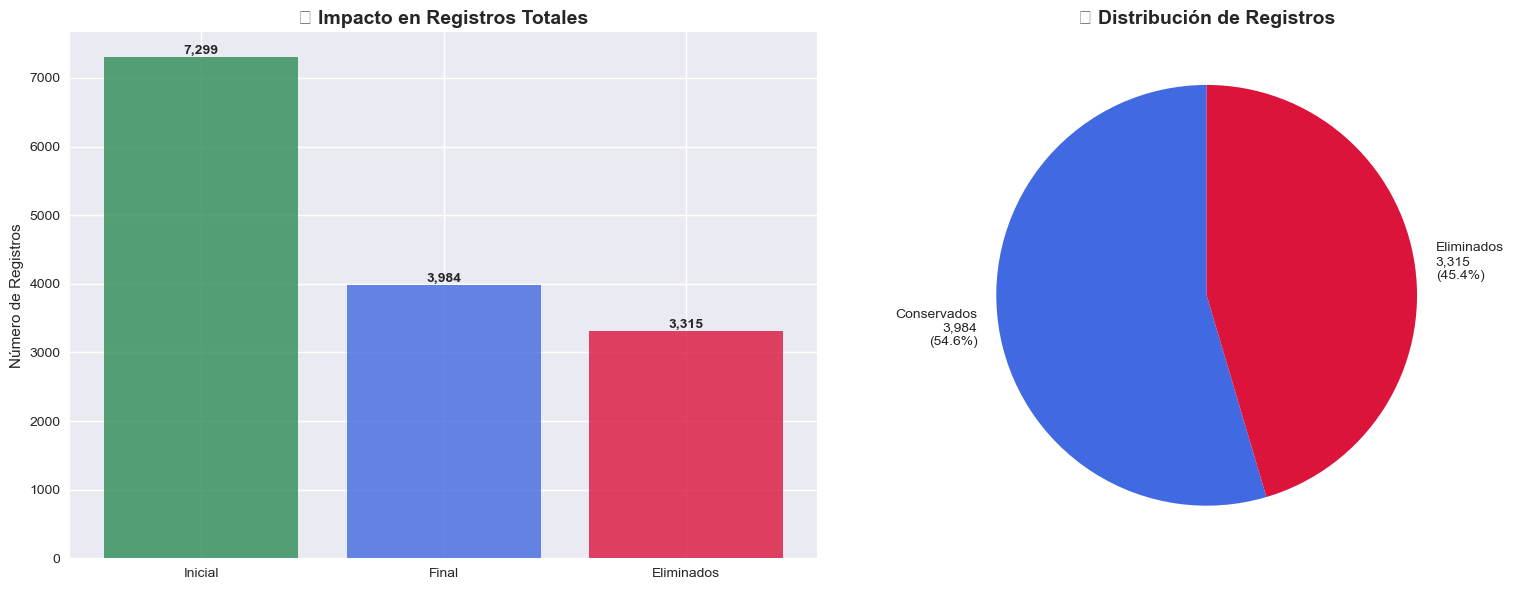

In [78]:
# %%
# GRÁFICOS COMPARATIVOS - REGISTROS Y USUARIOS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. GRÁFICO DE BARRAS COMPARATIVO - REGISTROS
records_data = ['Inicial', 'Final', 'Eliminados']
records_values = [initial_total, final_total, total_eliminated]
colors_records = ['#2E8B57', '#4169E1', '#DC143C']

bars1 = ax1.bar(records_data, records_values, color=colors_records, alpha=0.8)
ax1.set_title('📊 Impacto en Registros Totales', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Registros')

# Agregar valores encima de las barras
for bar, value in zip(bars1, records_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# 2. GRÁFICO DE PIE - PORCENTAJE DE REGISTROS
records_pie_data = [final_total, total_eliminated]
records_pie_labels = [f'Conservados\n{final_total:,}\n({(final_total/initial_total)*100:.1f}%)', 
                     f'Eliminados\n{total_eliminated:,}\n({(total_eliminated/initial_total)*100:.1f}%)']

wedges, texts, autotexts = ax2.pie(records_pie_data, labels=records_pie_labels, 
                                  colors=['#4169E1', '#DC143C'], autopct='',
                                  startangle=90, textprops={'fontsize': 10})

ax2.set_title('📈 Distribución de Registros', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [80]:
# %%
# Resumen simple del dataset limpio
print(f" DATASET LIMPIO FINAL:")
print(f"   • Nombre: df_clean")
print(f"   • Total registros: {len(df_clean):,}")
print(f"   • Total usuarios: {df_clean['Usuario_ID'].nunique():,}")
print(f"   • Total columnas: {df_clean.shape[1]}")

# Muestra de los datos limpios
print(f"\n📋 MUESTRA DE DATOS LIMPIOS:")
display(df_clean.head(10))

 DATASET LIMPIO FINAL:
   • Nombre: df_clean
   • Total registros: 3,984
   • Total usuarios: 10
   • Total columnas: 14

📋 MUESTRA DE DATOS LIMPIOS:


,ID,Usuario_ID,Smartwatch_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Estatus,Fecha_Registro,Fecha_Actualizacion
0,9,1,1,2025-07-12 00:21:49,53,96.000,72.000,97.800,36.700,18,49.700,1,2025-08-11 20:10:59,None
1,4882,7,7,2025-07-13 07:03:05,89,103.000,64.000,97.700,37.000,18,39.640,1,2025-08-11 20:10:59,None
2,4885,7,7,2025-07-13 07:02:28,84,101.000,78.000,99.000,37.000,22,41.000,1,2025-08-11 20:10:59,None
3,4878,7,7,2025-07-13 06:52:12,58,104.000,72.000,97.400,36.000,9,24.020,1,2025-08-11 20:10:59,None
4,4886,7,7,2025-07-13 05:34:12,49,119.000,78.000,96.400,36.100,7,40.040,1,2025-08-11 20:10:59,None
5,4868,7,7,2025-07-13 04:55:47,55,118.000,81.000,99.200,36.400,1,22.940,1,2025-08-11 20:10:59,None
6,4884,7,7,2025-07-13 04:31:54,63,107.000,75.000,97.700,36.200,22,39.310,1,2025-08-11 20:10:59,None
7,4874,7,7,2025-07-13 03:57:52,65,110.000,79.000,96.600,36.700,25,44.870,1,2025-08-11 20:10:59,None
8,4869,7,7,2025-07-13 01:36:23,67,99.000,66.000,97.500,36.800,10,26.400,1,2025-08-11 20:10:59,None
9,4842,7,7,2025-07-12 20:30:41,113,98.000,68.000,98.400,36.600,27,39.180,1,2025-08-11 20:10:59,None


In [82]:
print(f"\n INFO BÁSICA:")
df_clean.info()


 INFO BÁSICA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   3984 non-null   int64         
 1   Usuario_ID           3984 non-null   int64         
 2   Smartwatch_ID        3984 non-null   int64         
 3   Timestamp_medicion   3984 non-null   datetime64[ns]
 4   Frecuencia_cardiaca  3984 non-null   int64         
 5   Presion_sistolica    3984 non-null   float64       
 6   Presion_diastolica   3984 non-null   float64       
 7   Saturacion_oxigeno   3984 non-null   float64       
 8   Temperatura          3984 non-null   float64       
 9   Nivel_estres         3984 non-null   int64         
 10  Variabilidad_ritmo   3984 non-null   float64       
 11  Estatus              3984 non-null   int64         
 12  Fecha_Registro       3984 non-null   datetime64[ns]
 13  Fecha_Actualizacio

In [84]:
columnas_necesarias = [
    'ID', 'Usuario_ID', 'Timestamp_medicion', 'Frecuencia_cardiaca', 
    'Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 
    'Temperatura', 'Nivel_estres', 'Variabilidad_ritmo', 'Fecha_Registro'
]

df_clean = df_clean[columnas_necesarias]

print(f" DATASET FINAL:")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Columnas: {df_clean.shape[1]}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")

print(f"\n INFO FINAL:")
df_clean.info()

print(f"\n MUESTRA:")
display(df_clean.head())

 DATASET FINAL:
   • Registros: 3,984
   • Columnas: 11
   • Usuarios: 10

 INFO FINAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   3984 non-null   int64         
 1   Usuario_ID           3984 non-null   int64         
 2   Timestamp_medicion   3984 non-null   datetime64[ns]
 3   Frecuencia_cardiaca  3984 non-null   int64         
 4   Presion_sistolica    3984 non-null   float64       
 5   Presion_diastolica   3984 non-null   float64       
 6   Saturacion_oxigeno   3984 non-null   float64       
 7   Temperatura          3984 non-null   float64       
 8   Nivel_estres         3984 non-null   int64         
 9   Variabilidad_ritmo   3984 non-null   float64       
 10  Fecha_Registro       3984 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(4)
memory usage: 34

,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Fecha_Registro
0,9,1,2025-07-12 00:21:49,53,96.000,72.000,97.800,36.700,18,49.700,2025-08-11 20:10:59
1,4882,7,2025-07-13 07:03:05,89,103.000,64.000,97.700,37.000,18,39.640,2025-08-11 20:10:59
2,4885,7,2025-07-13 07:02:28,84,101.000,78.000,99.000,37.000,22,41.000,2025-08-11 20:10:59
3,4878,7,2025-07-13 06:52:12,58,104.000,72.000,97.400,36.000,9,24.020,2025-08-11 20:10:59
4,4886,7,2025-07-13 05:34:12,49,119.000,78.000,96.400,36.100,7,40.040,2025-08-11 20:10:59


# ANÁLISIS MÉDICO POR USUARIO

In [86]:
# %%
print("🏥 FILTRADO DE VALORES MÉDICAMENTE IMPOSIBLES")
print("=" * 60)

# Rangos médicamente compatibles con la vida (estrictos)
rangos_vitales = {
    'Frecuencia_cardiaca': (25, 250),      # 25: bradicardia extrema, 250: taquicardia máxima
    'Presion_sistolica': (50, 300),        # 50: hipotensión severa, 300: crisis hipertensiva
    'Presion_diastolica': (20, 200),       # 20: hipotensión extrema, 200: hipertensión maligna
    'Saturacion_oxigeno': (50, 100),       # 50: hipoxemia severa límite, 100: máximo posible
    'Temperatura': (28.0, 44.0),           # 28°C: hipotermia severa, 44°C: hipertermia crítica
    'Nivel_estres': (0, 10),               # Escala estándar 0-10
    'Variabilidad_ritmo': (1, 300)         # 1: mínima variabilidad, 300: máxima registrada
}

print("Rangos de supervivencia definidos:")
for variable, (min_val, max_val) in rangos_vitales.items():
    print(f"   • {variable}: {min_val} - {max_val}")

# Contar registros fuera de rangos de supervivencia
registros_iniciales = len(df_clean)
print(f"\n📊 ANÁLISIS DE REGISTROS FUERA DE RANGOS DE SUPERVIVENCIA:")

registros_a_eliminar = pd.Series([False] * len(df_clean))

for variable, (min_val, max_val) in rangos_vitales.items():
    if variable in df_clean.columns:
        fuera_rango = (df_clean[variable] < min_val) | (df_clean[variable] > max_val)
        count_fuera = fuera_rango.sum()
        
        if count_fuera > 0:
            print(f"   • {variable}: {count_fuera:,} registros fuera de rango")
            
            # Mostrar algunos ejemplos de valores extremos
            valores_extremos = df_clean[fuera_rango][variable]
            if len(valores_extremos) > 0:
                print(f"     - Valores ejemplo: {valores_extremos.head().tolist()}")
            
            registros_a_eliminar = registros_a_eliminar | fuera_rango
        else:
            print(f"   • {variable}: ✅ Todos los valores en rango de supervivencia")

total_a_eliminar = registros_a_eliminar.sum()
print(f"\n⚠️  TOTAL A ELIMINAR: {total_a_eliminar:,} registros ({total_a_eliminar/registros_iniciales*100:.2f}%)")

🏥 FILTRADO DE VALORES MÉDICAMENTE IMPOSIBLES
Rangos de supervivencia definidos:
   • Frecuencia_cardiaca: 25 - 250
   • Presion_sistolica: 50 - 300
   • Presion_diastolica: 20 - 200
   • Saturacion_oxigeno: 50 - 100
   • Temperatura: 28.0 - 44.0
   • Nivel_estres: 0 - 10
   • Variabilidad_ritmo: 1 - 300

📊 ANÁLISIS DE REGISTROS FUERA DE RANGOS DE SUPERVIVENCIA:
   • Frecuencia_cardiaca: ✅ Todos los valores en rango de supervivencia
   • Presion_sistolica: ✅ Todos los valores en rango de supervivencia
   • Presion_diastolica: ✅ Todos los valores en rango de supervivencia
   • Saturacion_oxigeno: ✅ Todos los valores en rango de supervivencia
   • Temperatura: ✅ Todos los valores en rango de supervivencia
   • Nivel_estres: 3,519 registros fuera de rango
     - Valores ejemplo: [18, 18, 22, 22, 25]
   • Variabilidad_ritmo: ✅ Todos los valores en rango de supervivencia

⚠️  TOTAL A ELIMINAR: 3,519 registros (88.33%)


In [88]:
# %%
# Mostrar casos específicos que se eliminarán
if total_a_eliminar > 0:
    print(f"\n🔍 CASOS ESPECÍFICOS A ELIMINAR:")
    casos_extremos = df_clean[registros_a_eliminar][['Usuario_ID', 'Timestamp_medicion'] + list(rangos_vitales.keys())]
    
    print("Primeros 10 casos con valores imposibles:")
    display(casos_extremos.head(10))
    
    # Análisis por usuario afectado
    usuarios_afectados = df_clean[registros_a_eliminar]['Usuario_ID'].nunique()
    print(f"\n👥 Usuarios afectados: {usuarios_afectados:,}")
    
    # Top usuarios con más casos imposibles
    casos_por_usuario = df_clean[registros_a_eliminar]['Usuario_ID'].value_counts().head(5)
    print(f"\nTop 5 usuarios con más casos imposibles:")
    for usuario, casos in casos_por_usuario.items():
        print(f"   • Usuario {usuario}: {casos} casos imposibles")

# ELIMINAR registros con valores imposibles
df_clean_vital = df_clean[~registros_a_eliminar].reset_index(drop=True)

print(f"\n✅ ELIMINACIÓN COMPLETADA:")
print(f"   • Registros antes: {registros_iniciales:,}")
print(f"   • Registros después: {len(df_clean_vital):,}")
print(f"   • Registros eliminados: {total_a_eliminar:,}")
print(f"   • Usuarios restantes: {df_clean_vital['Usuario_ID'].nunique():,}")

# Actualizar el dataframe principal
df_clean = df_clean_vital.copy()


🔍 CASOS ESPECÍFICOS A ELIMINAR:
Primeros 10 casos con valores imposibles:


,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo
0,1,2025-07-12 00:21:49,53,96.000,72.000,97.800,36.700,18,49.700
1,7,2025-07-13 07:03:05,89,103.000,64.000,97.700,37.000,18,39.640
2,7,2025-07-13 07:02:28,84,101.000,78.000,99.000,37.000,22,41.000
6,7,2025-07-13 04:31:54,63,107.000,75.000,97.700,36.200,22,39.310
7,7,2025-07-13 03:57:52,65,110.000,79.000,96.600,36.700,25,44.870
9,7,2025-07-12 20:30:41,113,98.000,68.000,98.400,36.600,27,39.180
10,7,2025-07-12 19:19:57,99,123.000,70.000,99.000,36.800,31,40.950
11,7,2025-07-12 18:08:00,100,115.000,83.000,97.600,36.700,33,33.780
12,7,2025-07-12 15:50:47,90,103.000,83.000,99.600,36.700,38,27.270
13,7,2025-07-12 15:39:03,98,104.000,73.000,100.000,36.800,25,40.550



👥 Usuarios afectados: 10

Top 5 usuarios con más casos imposibles:
   • Usuario 6: 585 casos imposibles
   • Usuario 2: 468 casos imposibles
   • Usuario 3: 452 casos imposibles
   • Usuario 5: 449 casos imposibles
   • Usuario 1: 273 casos imposibles

✅ ELIMINACIÓN COMPLETADA:
   • Registros antes: 3,984
   • Registros después: 465
   • Registros eliminados: 3,519
   • Usuarios restantes: 7


In [90]:
# %%
print(f"\n🎯 VERIFICACIÓN FINAL:")
print(f"   • Dataset: df_clean")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")
print(f"   • Valores médicamente imposibles: 0")

print(f"\n📊 RANGOS FINALES VERIFICADOS:")
for variable, (min_val, max_val) in rangos_vitales.items():
    if variable in df_clean.columns:
        actual_min = df_clean[variable].min()
        actual_max = df_clean[variable].max()
        print(f"   • {variable}: {actual_min:.1f} - {actual_max:.1f} (rango: {min_val}-{max_val})")

print(f"\n✅ DATASET MÉDICAMENTE VIABLE LISTO")


🎯 VERIFICACIÓN FINAL:
   • Dataset: df_clean
   • Registros: 465
   • Usuarios: 7
   • Valores médicamente imposibles: 0

📊 RANGOS FINALES VERIFICADOS:
   • Frecuencia_cardiaca: 45.0 - 118.0 (rango: 25-250)
   • Presion_sistolica: 90.0 - 140.0 (rango: 50-300)
   • Presion_diastolica: 60.0 - 94.0 (rango: 20-200)
   • Saturacion_oxigeno: 95.6 - 99.9 (rango: 50-100)
   • Temperatura: 35.9 - 37.0 (rango: 28.0-44.0)
   • Nivel_estres: 0.0 - 10.0 (rango: 0-10)
   • Variabilidad_ritmo: 21.3 - 55.0 (rango: 1-300)

✅ DATASET MÉDICAMENTE VIABLE LISTO


### Verificacion final 

In [100]:
# %%
print(f"\n🎯 VERIFICACIÓN FINAL:")
print(f"   • Dataset: df_clean")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")
print(f"   • Valores médicamente imposibles: 0")

print(f"\n📊 RANGOS FINALES VERIFICADOS:")
for variable, (min_val, max_val) in rangos_vitales.items():
   if variable in df_clean.columns:
       actual_min = df_clean[variable].min()
       actual_max = df_clean[variable].max()
       print(f"   • {variable}: {actual_min:.1f} - {actual_max:.1f} (rango: {min_val}-{max_val})")

print(f"\n✅ DATASET MÉDICAMENTE VIABLE LISTO")

# Mostrar el dataset final
print(f"\n📋 DATASET FINAL LIMPIO Y VIABLE:")
display(df_clean.head(10))

print(f"\n🔍 INFORMACIÓN DEL DATASET FINAL:")
df_clean.info()

print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
display(df_clean.describe().round(2))

# Registros por usuario
print(f"\n👥 REGISTROS POR USUARIO:")
registros_por_usuario = df_clean['Usuario_ID'].value_counts().sort_index()
registros_df = pd.DataFrame({
   'Usuario_ID': registros_por_usuario.index,
   'Total_Registros': registros_por_usuario.values
})

display(registros_df)

print(f"\n📊 RESUMEN DE DISTRIBUCIÓN:")
print(f"   • Promedio registros por usuario: {registros_por_usuario.mean():.1f}")
print(f"   • Mediana registros por usuario: {registros_por_usuario.median():.1f}")
print(f"   • Usuario con más registros: {registros_por_usuario.max():,}")
print(f"   • Usuario con menos registros: {registros_por_usuario.min():,}")


🎯 VERIFICACIÓN FINAL:
   • Dataset: df_clean
   • Registros: 465
   • Usuarios: 7
   • Valores médicamente imposibles: 0

📊 RANGOS FINALES VERIFICADOS:
   • Frecuencia_cardiaca: 45.0 - 118.0 (rango: 25-250)
   • Presion_sistolica: 90.0 - 140.0 (rango: 50-300)
   • Presion_diastolica: 60.0 - 94.0 (rango: 20-200)
   • Saturacion_oxigeno: 95.6 - 99.9 (rango: 50-100)
   • Temperatura: 35.9 - 37.0 (rango: 28.0-44.0)
   • Nivel_estres: 0.0 - 10.0 (rango: 0-10)
   • Variabilidad_ritmo: 21.3 - 55.0 (rango: 1-300)

✅ DATASET MÉDICAMENTE VIABLE LISTO

📋 DATASET FINAL LIMPIO Y VIABLE:


,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Fecha_Registro
0,4878,7,2025-07-13 06:52:12,58,104.000,72.000,97.400,36.000,9,24.020,2025-08-11 20:10:59
1,4886,7,2025-07-13 05:34:12,49,119.000,78.000,96.400,36.100,7,40.040,2025-08-11 20:10:59
2,4868,7,2025-07-13 04:55:47,55,118.000,81.000,99.200,36.400,1,22.940,2025-08-11 20:10:59
3,4869,7,2025-07-13 01:36:23,67,99.000,66.000,97.500,36.800,10,26.400,2025-08-11 20:10:59
4,4891,7,2025-07-14 01:56:18,54,101.000,81.000,97.100,36.600,0,39.980,2025-08-11 20:10:59
5,4896,7,2025-07-14 00:43:58,53,109.000,61.000,96.700,36.800,9,43.920,2025-08-11 20:10:59
6,4867,7,2025-07-13 23:16:20,69,125.000,77.000,96.200,36.200,0,25.340,2025-08-11 20:10:59
7,4847,7,2025-07-12 02:04:04,58,121.000,83.000,99.000,36.400,0,31.810,2025-08-11 20:10:59
8,4855,7,2025-07-12 00:27:47,63,95.000,74.000,96.700,36.900,0,42.520,2025-08-11 20:10:59
9,4980,7,2025-07-19 03:01:43,57,95.000,76.000,97.600,36.400,0,23.120,2025-08-11 20:10:59



🔍 INFORMACIÓN DEL DATASET FINAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   465 non-null    int64         
 1   Usuario_ID           465 non-null    int64         
 2   Timestamp_medicion   465 non-null    datetime64[ns]
 3   Frecuencia_cardiaca  465 non-null    int64         
 4   Presion_sistolica    465 non-null    float64       
 5   Presion_diastolica   465 non-null    float64       
 6   Saturacion_oxigeno   465 non-null    float64       
 7   Temperatura          465 non-null    float64       
 8   Nivel_estres         465 non-null    int64         
 9   Variabilidad_ritmo   465 non-null    float64       
 10  Fecha_Registro       465 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(4)
memory usage: 40.1 KB

📊 ESTADÍSTICAS DESCRIPTIVAS:


,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Fecha_Registro
count,465.000,465.000,465,465.000,465.000,465.000,465.000,465.000,465.000,465.000,465
mean,4475.780,6.430,2025-07-26 15:22:54.344086016,59.960,107.220,72.310,97.490,36.500,3.370,39.680,2025-08-11 20:10:59
min,7.000,1.000,2025-07-12 00:27:47,45.000,90.000,60.000,95.600,35.900,0.000,21.280,2025-08-11 20:10:59
25%,2601.000,4.000,2025-07-19 01:28:24,54.000,98.000,65.000,96.700,36.300,0.000,32.980,2025-08-11 20:10:59
50%,5389.000,7.000,2025-07-26 12:58:13,59.000,107.000,73.000,97.500,36.500,2.000,39.980,2025-08-11 20:10:59
75%,6347.000,9.000,2025-08-03 02:11:15,64.000,116.000,79.000,98.300,36.700,7.000,45.940,2025-08-11 20:10:59
max,7300.000,10.000,2025-08-11 23:22:21,118.000,140.000,94.000,99.900,37.000,10.000,54.950,2025-08-11 20:10:59
std,2352.630,3.120,NaN,9.300,10.670,7.610,0.930,0.280,3.740,8.300,NaN



👥 REGISTROS POR USUARIO:


,Usuario_ID,Total_Registros
0,1,80
1,3,1
2,4,79
3,7,79
4,8,71
5,9,81
6,10,74



📊 RESUMEN DE DISTRIBUCIÓN:
   • Promedio registros por usuario: 66.4
   • Mediana registros por usuario: 79.0
   • Usuario con más registros: 81
   • Usuario con menos registros: 1


### GUARDANDO DATASET LIMPIO EN data/processed/

In [112]:
# %%
print("💾 GUARDANDO DATASET LIMPIO EN UBICACIÓN CORRECTA")
print("=" * 50)

# Guardar en data/processed/ (no en data/raw/processed/)
df_clean.to_csv('data/processed/mediciones_cardiacas_clean.csv', index=False)
print("✅ CSV guardado: data/processed/mediciones_cardiacas_clean.csv")

df_clean.to_parquet('data/processed/mediciones_cardiacas_clean.parquet', index=False)
print("✅ Parquet guardado: data/processed/mediciones_cardiacas_clean.parquet")

# Metadatos
import json
from datetime import datetime

metadata = {
    "proceso_limpieza": {
        "fecha_procesamiento": datetime.now().isoformat(),
        "registros_finales": len(df_clean),
        "usuarios_finales": df_clean['Usuario_ID'].nunique(),
        "columnas_finales": list(df_clean.columns)
    }
}

with open('data/processed/cleaning_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadatos guardados: data/processed/cleaning_metadata.json")

print(f"\n✅ ARCHIVOS GUARDADOS CORRECTAMENTE EN: data/processed/")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")

💾 GUARDANDO DATASET LIMPIO EN UBICACIÓN CORRECTA
✅ CSV guardado: data/processed/mediciones_cardiacas_clean.csv
✅ Parquet guardado: data/processed/mediciones_cardiacas_clean.parquet
✅ Metadatos guardados: data/processed/cleaning_metadata.json

✅ ARCHIVOS GUARDADOS CORRECTAMENTE EN: data/processed/
   • Registros: 465
   • Usuarios: 7
